In [1]:
%cd ..

/home/ubuntu/AIVN-materials/image_analysis


In [2]:
import torch
from torch.nn import functional as F
from tqdm import tqdm
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
import matplotlib.pyplot as plt

from data import FlowerDataModule
from model import ClassificationModel

In [3]:
data_dir = "./data"
ckpt_path =  "/home/ubuntu/AIVN-materials/image_analysis/logs/vanila_mlp/lightning_logs/version_23/MNIST Classification/2ujerqza/checkpoints/epoch=0-step=1874-val_loss=0.00.ckpt"
dm = FlowerDataModule(data_dir=data_dir)
model = ClassificationModel().load_from_checkpoint(checkpoint_path=ckpt_path)

# Plot Representation

In [7]:
def extract_features(model, dataloader):
    features = []
    labels = []
    model.eval()
    for idx, batch in enumerate(tqdm(dataloader)):
        images, gts= batch
        # images = images.view(images.shape[0], -1)
        with torch.no_grad():
            feats = model.model(images)
        features.append(feats)
        labels.append(gts)
    features = torch.concat(features)
    labels = torch.concat(labels)
    return features, labels

In [8]:
features, labels, = extract_features(model, dm.val_dataloader())

100%|██████████| 1875/1875 [00:33<00:00, 56.50it/s] 


In [9]:
def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

def get_tsne(data, n_components=2, n_images=None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

def plot_representations(data, labels, n_images=None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=labels)

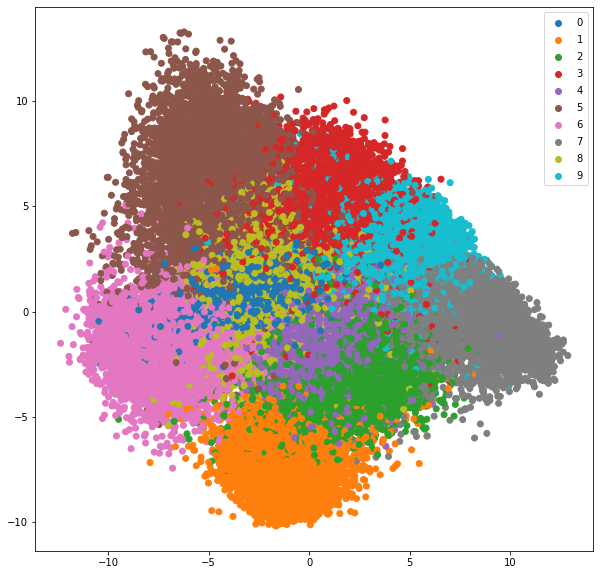

In [10]:
output_pca_data = get_pca(features)
plot_representations(output_pca_data, labels)

/home/ubuntu/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ubuntu/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


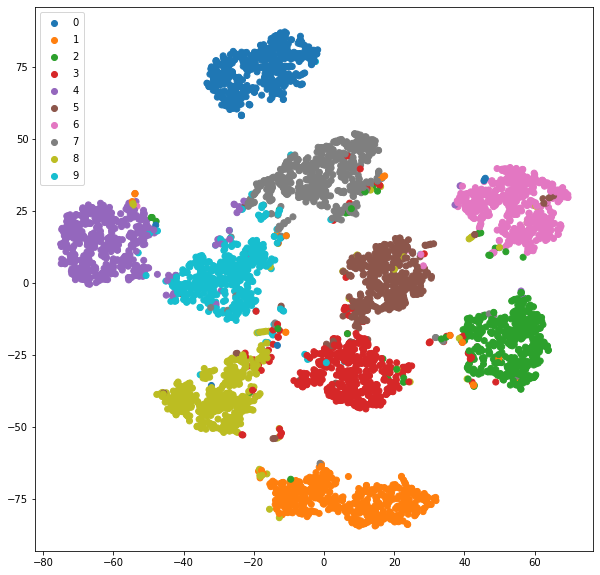

In [11]:
N_IMAGES = 5_000

output_tsne_data = get_tsne(features, n_images=N_IMAGES)
plot_representations(output_tsne_data, labels, n_images=N_IMAGES)

# Fake Input

In [16]:
def imagine_input(model, class_idx, n_iterations=50_000):

    model.eval()

    best_prob = 0
    best_image = None

    with torch.no_grad():

        for _ in range(n_iterations):

            x = torch.randn(32, 1, 28, 28)

            y_pred = model(x)

            preds = F.softmax(y_pred, dim=-1)

            _best_prob, index = torch.max(preds[:, class_idx], dim=0)

            if _best_prob > best_prob:
                best_prob = _best_prob
                best_image = x[index]

    return best_image, best_prob

In [17]:
DIGIT = 3

best_image, best_prob = imagine_input(model, DIGIT)

In [18]:
print(f'Best image probability: {best_prob.item()*100:.2f}%')

Best image probability: 100.00%
